In [1]:
import requests
import edi_pyagnostics as dia
import pandas as pd
import numpy as np

## Test the API (get latest version of an NPP package)

In [2]:
# Get the version number of the newest revision on EDI
params = (
    ('filter', 'newest'),
#    ('environment', 'staging')
)

response = requests.get('https://pasta.lternet.edu/package/eml/knb-lter-jrn/210011004', params=params)

In [3]:
response.headers

{'Server': 'nginx/1.14.0 (Ubuntu)', 'Date': 'Wed, 26 Aug 2020 03:10:01 GMT', 'Content-Type': 'text/plain', 'Content-Length': '2', 'Connection': 'keep-alive', 'Web-Service': 'DataPackageManager-1.0'}

In [4]:
print(response.content) #This gives server response in bytes - useful for binary data
response.text # Server response as text (more useful for xml)

b'82'


'82'

## Get more recent changes

In [5]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2020-05-02'),
    #('toDate', '2020-05-01'),
    ('scope', 'knb-lter-jrn'))#,
#    ('environment', 'production'))

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [6]:
# Response = long XML string that can be parsed with elementtree, beautifulsoup, etc
response.text[0:300] # now parse this with 

'<dataPackageChanges>\n  <dataPackage>\n    <packageId>knb-lter-jrn.210385003.12</packageId>\n    <scope>knb-lter-jrn</scope>\n    <identifier>210385003</identifier>\n    <revision>12</revision>\n    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>\n    <doi>doi:10.6073/pasta/d267dbfcacf70475e'

In [7]:
# Parse the xml into an "ElementTree" object called root
import xml.etree.ElementTree as ET

tree_1 = ET.parse('knb-lter-jrn_20190101-20191231.xml')
root_1 = tree_1.getroot()

tree_2 = ET.parse('knb-lter-jrn_20200101-20200501.xml')
root_2 = tree_2.getroot()

root = ET.fromstring(response.text)

In [8]:
# Number of elements (EDI changes) in root
print(len(root_1))
print(len(root_2))
len(root)

815
676


656

In [26]:
# You can iterate by tag (may depend on nesting)
# first 5 "serviceMethods"
i=0
for sm in root.iter('serviceMethod'):
    if i < 5: print(sm.text)
    i=i+1

updateDataPackage
updateDataPackage
updateDataPackage
updateDataPackage
updateDataPackage


In [9]:
# First 5 package IDs
i=0
for ID in root.iter('identifier'):
    if i < 5: print(ID.text)
    i=i+1

210385003
210385007
210338005
210001003
210548016


## Parse the data sent from EDI

In [25]:
# Create a dataframe from the entire record in root
df_1 = pd.DataFrame({'date':[date.text for date in root_1.iter('date')],
                   'pkgid':[int(ID.text) for ID in root_1.iter('identifier')],
                   'action':[sm.text for sm in root_1.iter('serviceMethod')]}
                   )
df_2 = pd.DataFrame({'date':[date.text for date in root_2.iter('date')],
                   'pkgid':[int(ID.text) for ID in root_2.iter('identifier')],
                   'action':[sm.text for sm in root_2.iter('serviceMethod')]}
                   )


df_old = pd.concat([df_1, df_2])

# Create a dataframe from the entire record in root
df = pd.DataFrame({'date':[date.text for date in root.iter('date')],
                   'pkgid':[int(ID.text) for ID in root.iter('identifier')],
                   'action':[sm.text for sm in root.iter('serviceMethod')]}
                   )
df = pd.concat([df_old,df])

print(len(df))

print(df.head())

df.tail()

2147
                      date      pkgid             action
0  2019-03-01T12:53:17.423  210437040  createDataPackage
1  2019-04-02T14:07:37.967  210351003  createDataPackage
2  2019-04-02T17:18:54.615  210351003  updateDataPackage
3  2019-04-05T14:47:35.236  210328003  createDataPackage
4  2019-04-08T14:03:09.964  210328003  updateDataPackage


,date,pkgid,action
651,2020-08-07T19:45:36.609,210437115,updateDataPackage
652,2020-08-07T19:46:44.495,210437116,updateDataPackage
653,2020-08-07T19:50:51.971,210437117,updateDataPackage
654,2020-08-07T19:54:02.924,210437118,updateDataPackage
655,2020-08-07T19:57:08.984,210437119,updateDataPackage


In [26]:
df.shape

(2147, 3)

In [27]:
# Make the index the date
df.index = pd.to_datetime(df['date'])#, format='%Y-%b-%dT%H:%M:%S.%f')

In [28]:
# Add columns - number of updates and creates, + extracted study id
df['n_update'] = 0
df['n_create'] = 0
df['n_delete'] = 0
df['n_tot'] = 0
df['studyid'] = df.pkgid.astype(str).str[-6:-3] #convert to str, studyid excludes mistaken 0

In [29]:
# Fill in number of updates or create for each record
df.loc[df.action=='updateDataPackage','n_update'] = 1
df.loc[df.action=='createDataPackage','n_create'] = 1
df.loc[df.action=='deleteDataPackage','n_delete'] = 1
# for totals, create = +1, delete = -1
df.loc[df.action=='createDataPackage','n_tot'] = 1
df.loc[df.action=='deleteDataPackage','n_tot'] = -1
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2019-03-01 12:53:17.423,2019-03-01T12:53:17.423,210437040,createDataPackage,0,1,0,1,437
2019-04-02 14:07:37.967,2019-04-02T14:07:37.967,210351003,createDataPackage,0,1,0,1,351
2019-04-02 17:18:54.615,2019-04-02T17:18:54.615,210351003,updateDataPackage,1,0,0,0,351
2019-04-05 14:47:35.236,2019-04-05T14:47:35.236,210328003,createDataPackage,0,1,0,1,328
2019-04-08 14:03:09.964,2019-04-08T14:03:09.964,210328003,updateDataPackage,1,0,0,0,328


In [30]:
# There are duplicate deletions (9 at last count)
df_dd = df.drop_duplicates()
n_dupdeletes = df.shape[0] - df_dd.shape[0]
df = df_dd
# Count deleted packages
deleted_pkgs = df.loc[df.action=='deleteDataPackage','pkgid']
print(df.shape)
deleted_pkgs

(2147, 8)


date
2019-06-04 11:54:10.258     21038001
2019-09-12 09:34:13.603    210860002
Name: pkgid, dtype: int64

## Create daily data file

In [31]:
startdt = "2019-11-01"

dfs = df.loc[df.index > startdt,['n_update', 'n_create', 'n_tot']].resample('D').sum()

## Plot activity since last report (2019-10-31)


In [32]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [33]:
# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

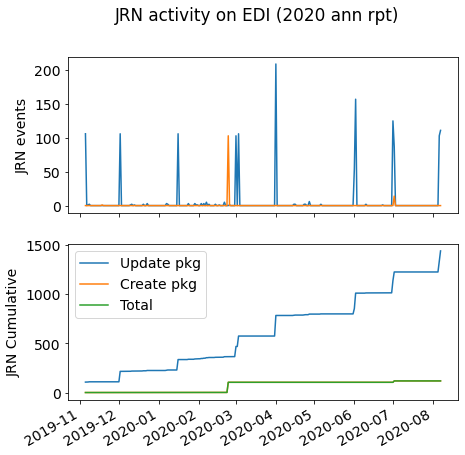

In [34]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(dfs.index, dfs.n_update, label='Update pkg')
ax[0].plot(dfs.index, dfs.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(dfs.index, dfs.n_update.cumsum(), label='Update pkg')
ax[1].plot(dfs.index, dfs.n_create.cumsum(), label='Create pkg')
ax[1].plot(dfs.index, dfs.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (2020 ann rpt)')
plt.legend()

import os
fig.savefig(os.path.expanduser("/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_EDI_annual_{0}.png".format(now)),
            dpi=150)

### Total number of packages

In [35]:
dfs.n_tot.sum()

118

## Plot activity since last report (excluding Met)

In [36]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
dfs_nomet = df.loc[np.logical_and(nomet, df.index > startdt),
                         ['n_update', 'n_create', 'n_tot']].resample('D').sum()
dfs_nomet.head()

,n_update,n_create,n_tot
date,,,
2019-11-07,1,0,0
2019-11-08,2,0,0
2019-11-09,0,0,0
2019-11-10,0,0,0
2019-11-11,0,0,0


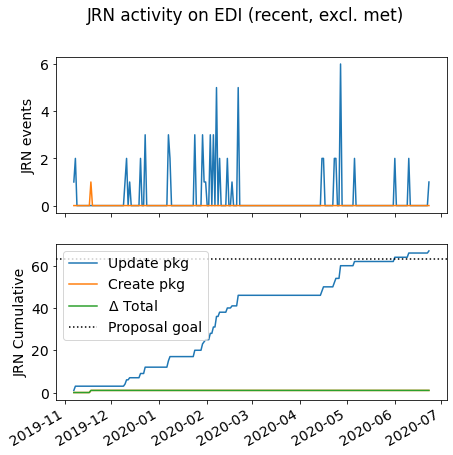

In [37]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(dfs_nomet.index, dfs_nomet.n_update, label='Update pkg')
ax[0].plot(dfs_nomet.index, dfs_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(dfs_nomet.index, dfs_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(dfs_nomet.index, dfs_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(dfs_nomet.index, dfs_nomet.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent, excl. met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_EDI_AnnNoMet_{0}.png".format(now)),
            dpi=150)

## Summary since last Annual Report

In [50]:
# Unique packages updated (excluding met)
rEDI = df.loc[df.index > startdt,]
rEDI_nomet = np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548')
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
len(uniqueUp)

1439
[210437031 210437016 210437046 210437061 210437001 210437091 210437076
 210437032 210437017 210437047 210437062 210437002 210437092 210437077
 210437033 210437018 210437048 210437063 210437003 210437093 210437078
 210437034 210437019 210437049 210437064 210437004 210437094 210437079
 210437106 210437035 210437020 210437050 210437065 210437005 210437095
 210437080 210437036 210437021 210437051 210437066 210437006 210437096
 210437081 210437037 210437022 210437052 210437067 210437007 210437097
 210437082 210437038 210437023 210437053 210437068 210437008 210437098
 210437083 210437039 210437024 210437054 210437069 210437009 210437099
 210437084 210437040 210437025 210437055 210437070 210437010 210437100
 210437085 210437041 210437011 210437026 210437056 210437071 210437086
 210437101 210437042 210437027 210437057 210437072 210437012 210437087
 210437102 210437043 210437028 210437058 210437073 210437013 210437103
 210437088 210437044 210437029 210437059 210437074 210437014 210437104
 

273

In [55]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('2020AR_unique_EDI_updates.txt', 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437031',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437016',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437046',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437061',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437091',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437076',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437032',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437017',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437047',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437062',

In [41]:
# Unique updates since last meeting
last_meeting = '2019-11-01'

vrEDI = df.loc[df.index >= last_meeting]
vrEDI_nomet = np.logical_and(vrEDI.studyid!='437', vrEDI.studyid!='548')
uR = vrEDI.loc[np.logical_and(vrEDI_nomet, vrEDI.action=='updateDataPackage'),].pkgid.unique()
# Unique updates before last meeting (to startdt)
oEDI = df.loc[np.logical_and(df.index > startdt, df.index < last_meeting),]
uO = oEDI.loc[np.logical_and(oEDI.studyid!='437', oEDI.action=='updateDataPackage'),].pkgid.unique()
print(uR)
print(uO)

[210412001 210012001 210012002 210010001 210086002 210086001 210122001
 210380001 210328001 210328002 210328003 210308001 210308002 210308003
 210308005 210126003 210262001 210262004 210262005 210128001 210128002
 210262008 210392001 210379001 210379002 210379003 210287001 210278002
 210278001 210338006 210338004 210338002 210351002 210351001 210011003
 210425001 210262010 210365001 210385001 210385004 210351003 210385005
 210385006 210385008 210385002 210385003 210385007 210338005 210001003
       100 210001001]
[]


In [42]:
uR[~np.in1d(uR, uO)]

array([210412001, 210012001, 210012002, 210010001, 210086002, 210086001,
       210122001, 210380001, 210328001, 210328002, 210328003, 210308001,
       210308002, 210308003, 210308005, 210126003, 210262001, 210262004,
       210262005, 210128001, 210128002, 210262008, 210392001, 210379001,
       210379002, 210379003, 210287001, 210278002, 210278001, 210338006,
       210338004, 210338002, 210351002, 210351001, 210011003, 210425001,
       210262010, 210365001, 210385001, 210385004, 210351003, 210385005,
       210385006, 210385008, 210385002, 210385003, 210385007, 210338005,
       210001003,       100, 210001001])

In [43]:
# Unique packages deleted
uniqueDel = rEDI.loc[np.logical_and(rEDI_nomet, rEDI.action=='deleteDataPackage'),].pkgid.unique()
uniqueDel

array([], dtype=int64)

In [46]:
# Unique packages created (See above)
uniqueCreate = rEDI.loc[rEDI.action=='createDataPackage',].pkgid.unique()
print(uniqueCreate)
len(uniqueCreate)

[      100 210548016 210548031 210548076 210548046 210548025 210548061
 210548001 210548040 210548085 210548055 210548099 210548026 210548070
 210548010 210548041 210548086 210548056 210548100 210548027 210548071
 210548011 210548042 210548087 210548057 210548028 210548072 210548012
 210548043 210548088 210548058 210548101 210548029 210548073 210548013
 210548044 210548089 210548059 210548102 210548030 210548074 210548014
 210548045 210548090 210548060 210548103 210548017 210548015 210548075
 210548032 210548077 210548047 210548091 210548018 210548062 210548002
 210548033 210548078 210548048 210548092 210548019 210548063 210548003
 210548034 210548004 210548079 210548049 210548093 210548020 210548064
 210548035 210548080 210548005 210548050 210548094 210548021 210548065
 210548036 210548081 210548051 210548095 210548022 210548066 210548006
 210548037 210548082 210548052 210548096 210548023 210548067 210548007
 210548038 210548083 210548053 210548097 210548024 210548068 210548008
 21054

118